# EGARCH-SVM Hybrid Model

## Load Data

In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,return2,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_21D_ahead
Date,,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.015681,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.274772
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.097191,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.517003


In [3]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
r_train, r_test = df['return'][:train_size], df['return'][train_size:]
RV_train, RV_test = df['RV'][:train_size], df['RV'][train_size:]

print("Training Set:", r_train.shape, RV_train.shape)
print("Test Set:", r_test.shape, RV_test.shape)
print(r_train.index[0], r_test.index[0])

Training Set: (1662,) (1662,)
Test Set: (416,) (416,)
2019-06-23 2024-01-10


In [4]:
date_ticks = ['2024-01-10', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-01']

In [5]:
def garch_svr_hybrid(log_returns):
    """
    Parameters:
    log_returns (array-like): Daily log return series r₁,..rₙ for the asset
    
    Returns:
    tuple: (forecasted_epsilon_squared, garch_forecast, svr_forecast)
    """
    
    # Step 1: Estimate GARCH parameters with ML method
    # Using GARCH(1,1) model
    garch_model = arch_model(log_returns, vol='Garch', p=1, q=1, rescale=False)
    garch_results = garch_model.fit(disp='off')
    
    # Step 2: Compute in-sample conditional variances σ²₁,..,σ²ₙ
    conditional_variances = garch_results.conditional_volatility**2
    
    # Step 3: Compute sequence M₁,..,Mₙ where Mₜ = ε²ₜ - σ²ₜ
    residuals = garch_results.resid
    epsilon_squared = residuals**2
    M_sequence = epsilon_squared - conditional_variances
    
    # Prepare data matrix for SVR training
    X = np.column_stack([
        conditional_variances[:-1],  # σ²ₜ₋₁
        M_sequence[:-1],             # Mₜ₋₁
        epsilon_squared[:-1]         # ε²ₜ₋₁
    ])
    y = M_sequence[1:]               # Mₜ (target)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Step 4: Train SVR on the data matrix
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_scaled, y)
    
    # Prepare the most recent data point for forecasting
    last_X = np.array([
        conditional_variances.iloc[-1],   # σ²ₙ
        M_sequence.iloc[-1],              # Mₙ
        epsilon_squared.iloc[-1]          # ε²ₙ
    ]).reshape(1, -1)
    last_X_scaled = scaler.transform(last_X)
    
    # Step 5: Compute one-day-ahead forecast of Mₙ₊₁ with SVR
    M_forecast = svr_model.predict(last_X_scaled)[0]
    
    # Step 6: Compute one-day-ahead forecast of σₙ₊₁ using GARCH model
    garch_forecast = garch_results.forecast(horizon=1)
    sigma_forecast = garch_forecast.variance.values[-1, 0]
    
    # Step 7: Compute forecasted value of ε²ₙ₊₁ = Mₙ₊₁ + σ²ₙ₊₁
    epsilon_squared_forecast = M_forecast + sigma_forecast
    
    return epsilon_squared_forecast, sigma_forecast, M_forecast


In [6]:
# Run the hybrid model
forecast, sigma_fc, M_fc = garch_svr_hybrid(r_train)

print(f"Forecasted ε²ₙ₊₁: {forecast:.6f}")
print(f"GARCH forecast σ²ₙ₊₁: {sigma_fc:.6f}")
print(f"SVR forecast Mₙ₊₁: {M_fc:.6f}")

Forecasted ε²ₙ₊₁: 0.091059
GARCH forecast σ²ₙ₊₁: 0.003721
SVR forecast Mₙ₊₁: 0.087338


In [7]:
predicted_volatility = []
for i in range(len(r_test)):
    log_returns = pd.concat([r_train, r_test[:i]])
    _, sigma_fc, _ = garch_svr_hybrid(log_returns)
    predicted_volatility.append(sigma_fc)
predicted_volatility = pd.DataFrame(predicted_volatility, index = r_test.index)

# Save the predicted values
predicted_volatility.to_csv('../res/1D/GARCH-SVM.csv', index=False)

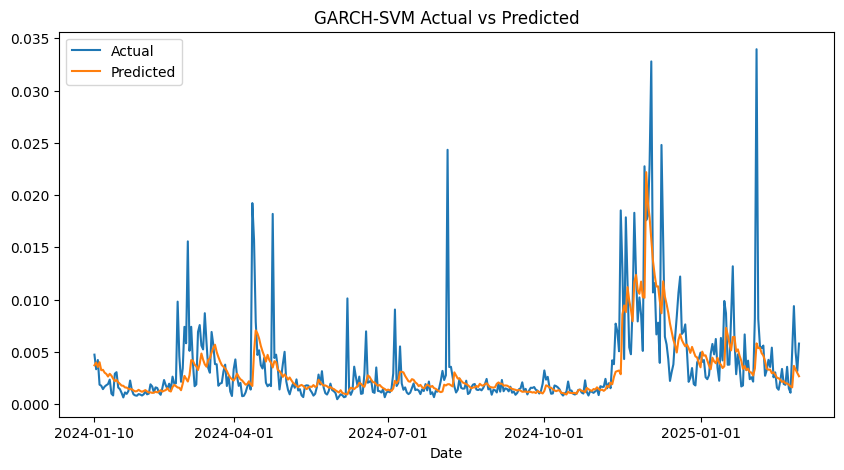

In [8]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(RV_test, label='Actual')
plt.plot(predicted_volatility, label='Predicted')
plt.title("GARCH-SVM Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/1D/GARCH-SVM_Actual_vs_Predicted.png')